# GleanerIO SHACL processor  (MagIC Implementation)

## About

This is the start of a validation notebook for MagIC.  The goal is to use this to
explore approaches to helping align publishers to application.  In this case, MagIC
to GeoCODES with a focus on versioning approaches.

## Notes
Need to address the sg scatter pattern 

## Imports

These are the imports need to run this notebook.

In [1]:
import dask
import pandas as pd
import json
import s3fs
import kglab
from rdflib import Graph  #, plugin
import getpass
import plotly.express as px

## Set up Dask client

We use dask to help speed up the processing.  Working with Dask is a bit of a higher bar, but the benefits are worth the effort.  See the [Dask](https://dask.org/) web site for more information on setting up and working with Dask.

In [2]:
from dask.distributed import Client    #, progress
client = Client(threads_per_worker=10, n_workers=4)
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 40,Total memory: 31.17 GiB
Comm: tcp://127.0.0.1:32857,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 40
Started: Just now,Total memory: 31.17 GiB
Comm: tcp://127.0.0.1:34707,Total threads: 10
Dashboard: http://127.0.0.1:38465/status,Memory: 7.79 GiB
Nanny: tcp://127.0.0.1:41597,


## File Access

This notebook is desgined to work in collaboration with the [GleanerIO](https://gleaner.io) suite.  GleanerIO uses an object store system based on S3.  Typically this is in [Minio](https://min.io) but any S3 compatible object store can be used.  If your object store requires credentials you will need to address that need here.  An example is given using the getpass library.

In [66]:
# Set the shapegraph to use
sg = './shapes/geocodes_magic.ttl'

# Anonymous S3 File system
oss = s3fs.S3FileSystem(
    anon=True,
    client_kwargs = {"endpoint_url":"https://oss.geodex.org"}
)

# Access controlled s3

# ACCESS_CODE = getpass.getpass()
# SECRET_CODE = getpass.getpass()

# oss = s3fs.S3FileSystem(
#     anon=False,
#     key=ACCESS_CODE,
#     secret=SECRET_CODE,
#     client_kwargs = {"endpoint_url":"http://192.168.86.45:49159"}
# )

In [40]:
# [optional] List the directories we can work with later
# oss.ls('gleaner/summoned')

### Definitions

This is the function used to process the JSON-LD file with the SHACL shape using the pySHACL library.

In [41]:
# SHACL function
@dask.delayed()
def read_and_validate(fn):
    # make a kg to hold our data graph
    namespaces = {
        "schema":  "https://schema.org/",
        "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

    kg = kglab.KnowledgeGraph(
        name = "Schema.org based datagraph",
        base_uri = "https://example.org/id/",
        namespaces = namespaces,
    )

    ## this is a mess.   no need to load to a graph objet to validate.  also, 
    ## can we load up the graph first and then validate later for everythng?
    with oss.open(fn, 'rb') as f:
        jld = json.loads(f.read().decode("utf-8", "ignore").replace('\n',' '))
        jlds = json.dumps(jld)

        g = Graph().parse(data=jlds, format='json-ld')
        context = {
            "@vocab": "https://schema.org/",
        }

        ttl = g.serialize(format='ttl', context=context, indent=4)
        kg.load_rdf_text(ttl, format="ttl", base=None)

        conforms, report_graph, report_text = kg.validate(
            shacl_graph=sg,
            shacl_graph_format="ttl"
        )

        return report_graph.save_rdf_text()  # return graph object or string of graph

## Process the files

This will list all the objects in the target bucket prefix in the fns variable.  This will then be used to set up the functions with Dask on which the compute call is made.  This cell can take from a few seconds to several minutes to run based on the number of objects and the network bandwidth available.  You can often monitor this via the Dask dashboard usually found at: http://127.0.0.1:8787/status.


In [67]:
%%time

fns = oss.ls('gleaner/summoned/magic')
o = [read_and_validate(f) for f in fns]

results = dask.compute(*o)  

CPU times: user 24.8 s, sys: 1.63 s, total: 26.4 s
Wall time: 1min 45s


### Load results

We will now load the results into an kglab graph which is basedon the rdflib graph.  This will let us do some simple SPARQL
based queries and review the results.  You could load this into a stand alone triple store like Jena or similar if you prefer.

In [68]:
%%time

rnamespaces = {
    "schema":  "https://schema.org/",
    "shacl":   "http://www.w3.org/ns/shacl#" ,
}

rkg = kglab.KnowledgeGraph(
    name = "Schema.org shacl eval datagraph",
    base_uri = "https://example.org/id/",
    namespaces = rnamespaces,
)

for r in results:
    rkg.load_rdf_text(data=r, format="ttl")

CPU times: user 33.7 s, sys: 169 ms, total: 33.8 s
Wall time: 33.5 s


## SPARQL

The following are the SPARQL queries we will use.  Be mindful of the fact pySHACL has type ValidationReport and ValidationResult when looking to see counts and results.

In [58]:
##

bc = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX sh: <http://www.w3.org/ns/shacl#>
SELECT  ?tid ?b
  WHERE {
    ?tid rdf:type sh:ValidationReport .  
    ?tid sh:conforms ?b .
  }

"""

sparql = """
SELECT ?path ?value ?constraint ?severity ?message ?id ?focus
  WHERE {
    ?id rdf:type shacl:ValidationResult .
    ?id shacl:focusNode ?focus .
    ?id shacl:resultMessage ?message .
    ?id shacl:resultSeverity ?severity .
    ?id shacl:sourceConstraintComponent ?constraint .
    OPTIONAL {
        ?id shacl:resultPath ?path .
    }
    OPTIONAL {
        ?id shacl:value ?value .
    }
  }
"""



In [59]:
df0 = rkg.query_as_df(bc)
df = df0.to_pandas()

mask = df.applymap(type) != bool
d = {True: 'TRUE', False: 'FALSE'}
df = df.where(mask, df.replace(d))

dfc = df.groupby('b').count().reset_index().rename(columns={'tid': 'Count'})

In [60]:
fig = px.pie(dfc, values='Count', names='b',  title='SHACL Validation Status', hole = 0.4,)
fig.show()

In [69]:
pdf = rkg.query_as_df(sparql)
df = pdf.to_pandas()
df.style.background_gradient(cmap='Blues')

dfc = df.groupby('severity').count().reset_index().rename(columns={'path': 'Count'})

ctst = pd.crosstab(df['message'], df['severity'], margins = True, margins_name = 'Subtotals')
ctst

severity,sh:Violation,sh:Warning,Subtotals
message,,,
Descriptions should be provided,1,0,1
Graph must have an ID,4255,0,4255
Keywords should be provided,0,2274,2274
Name should be provided,1,0,1
Provider information not listed,2876,0,2876
"Version missing, not typed integer, cardinality",9,0,9
Subtotals,7142,2274,9416


<AxesSubplot:xlabel='severity', ylabel='message'>

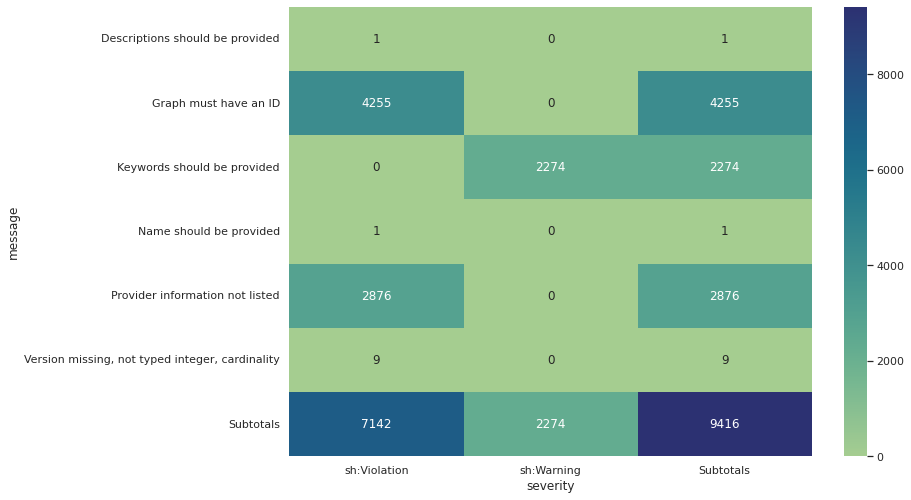

In [70]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns

cmap = sns.cm.crest
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(ctst, annot=True, fmt=".0f", cmap = cmap)

# Filter

Filter out some of the results for inspection

In [63]:
isVersion = df['path']==":version"
df_version = df[isVersion]
df_version

,path,constraint,severity,message,id,focus,value
989,:version,sh:MinCountConstraintComponent,sh:Violation,Version needed or not typed integer,_:ne16965a48dfe42cf99c4096854e6253bb2,_:ne16965a48dfe42cf99c4096854e6253bb3,None
1898,:version,sh:DatatypeConstraintComponent,sh:Violation,Version needed or not typed integer,_:n289fb0200b6343f19900795375e47e7fb4,_:n289fb0200b6343f19900795375e47e7fb3,1
2793,:version,sh:DatatypeConstraintComponent,sh:Violation,Version needed or not typed integer,_:n00263447f3d4465e9d64e057cb2dd2f9b2,<http://dx.doi.org/10.7288/V4/MAGIC/16240>,4
3932,:version,sh:DatatypeConstraintComponent,sh:Violation,Version needed or not typed integer,_:n6ac68b30c14c47d5b9ce7507a3caef1fb3,<http://dx.doi.org/10.7288/V4/MAGIC/16238>,3
4017,:version,sh:DatatypeConstraintComponent,sh:Violation,Version needed or not typed integer,_:n6e0c4a17c9cd41a5b1d417cad9fd4ef8b3,<http://dx.doi.org/10.7288/V4/MAGIC/16233>,1
5259,:version,sh:MinCountConstraintComponent,sh:Violation,Version needed or not typed integer,_:ne00520b8807848af885724cb0ee26883b4,_:ne00520b8807848af885724cb0ee26883b3,None
6026,:version,sh:DatatypeConstraintComponent,sh:Violation,Version needed or not typed integer,_:ne15c697a82904a60a7cee6080efb2f9fb4,_:ne15c697a82904a60a7cee6080efb2f9fb3,6
7929,:version,sh:DatatypeConstraintComponent,sh:Violation,Version needed or not typed integer,_:ncbaa55aa034048a3b1a5efaa6e3f84e7b2,<http://dx.doi.org/10.7288/V4/MAGIC/16258>,5
9065,:version,sh:DatatypeConstraintComponent,sh:Violation,Version needed or not typed integer,_:neb79e12f8212442aa31e8500ff701d69b2,<http://dx.doi.org/10.7288/V4/MAGIC/16237>,2


In [64]:
fig = px.pie(dfc, values='Count', names='severity',  title='SHACL Severity Counts', hole = 0.4,)
fig.show()

## Save to file

We can save the results to a CSV (or Parquet) file

In [65]:
# TODO export to parquet and or CSV
# df.to_parquet("./output/eco_opentopo_SHACL.parquet")
df.to_csv("./output/geodex_magic.csv")